In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
counter = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        counter+=1
print('Total files count = ',counter)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Total files count =  4602


# Importing Data files

In [2]:
Brain_Tumor_files_path = r'../input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
Healthy_files_path = r'../input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'

Images_path = [] #List to store location of all images.
Labels= [] #List to store labels of 0 or 1 for images.
dict_list = [Brain_Tumor_files_path, Healthy_files_path]

for i, j in enumerate(dict_list):
    image_list=os.listdir(j)
    for f in image_list:
        image_path=os.path.join(j,f)
        Images_path.append(image_path)
        if i==0:
          Labels.append('Cancer')
        else:
          Labels.append('Healthy') 
    
data = pd.DataFrame()
data['Images_path'] = Images_path
data['Labels'] = Labels
print(data.head())

                                         Images_path  Labels
0  ../input/brian-tumor-dataset/Brain Tumor Data ...  Cancer
1  ../input/brian-tumor-dataset/Brain Tumor Data ...  Cancer
2  ../input/brian-tumor-dataset/Brain Tumor Data ...  Cancer
3  ../input/brian-tumor-dataset/Brain Tumor Data ...  Cancer
4  ../input/brian-tumor-dataset/Brain Tumor Data ...  Cancer


# Exploratory Data Analysis

In [3]:
data.shape

(4600, 2)

In [4]:
data.describe()

,Images_path,Labels
count,4600,4600
unique,4600,2
top,../input/brian-tumor-dataset/Brain Tumor Data ...,Cancer
freq,1,2513


Text(0.5, 1.0, 'Count plot of Labels')

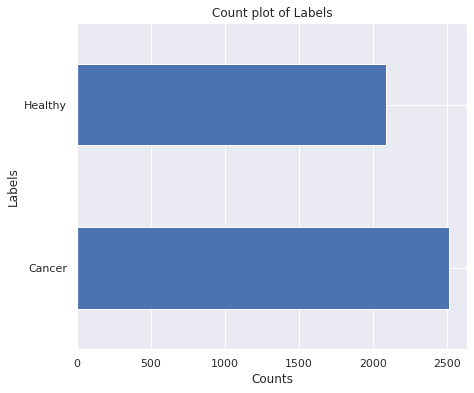

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
data.Labels.value_counts().plot(kind='barh', figsize=(7, 6))
plt.ylabel('Labels')
plt.xlabel('Counts')
plt.title('Count plot of Labels')

Text(0.5, 1.0, 'Count plot of Labels')

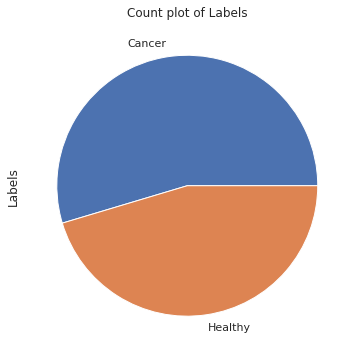

In [6]:
data.Labels.value_counts().plot(kind='pie', figsize=(7, 6))
plt.title('Count plot of Labels')

# Splitting Data

In [7]:
from sklearn.model_selection import train_test_split as TTS
train_images, test_images = TTS(data, test_size=0.3, random_state=101)
train_set, val_set = TTS(data, test_size=0.2, random_state=101)

print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


# Image Data Generation

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="Images_path",y_col="Labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="Images_path", y_col="Labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="Images_path", y_col="Labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


# Visualizing Images of Brain

In [9]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

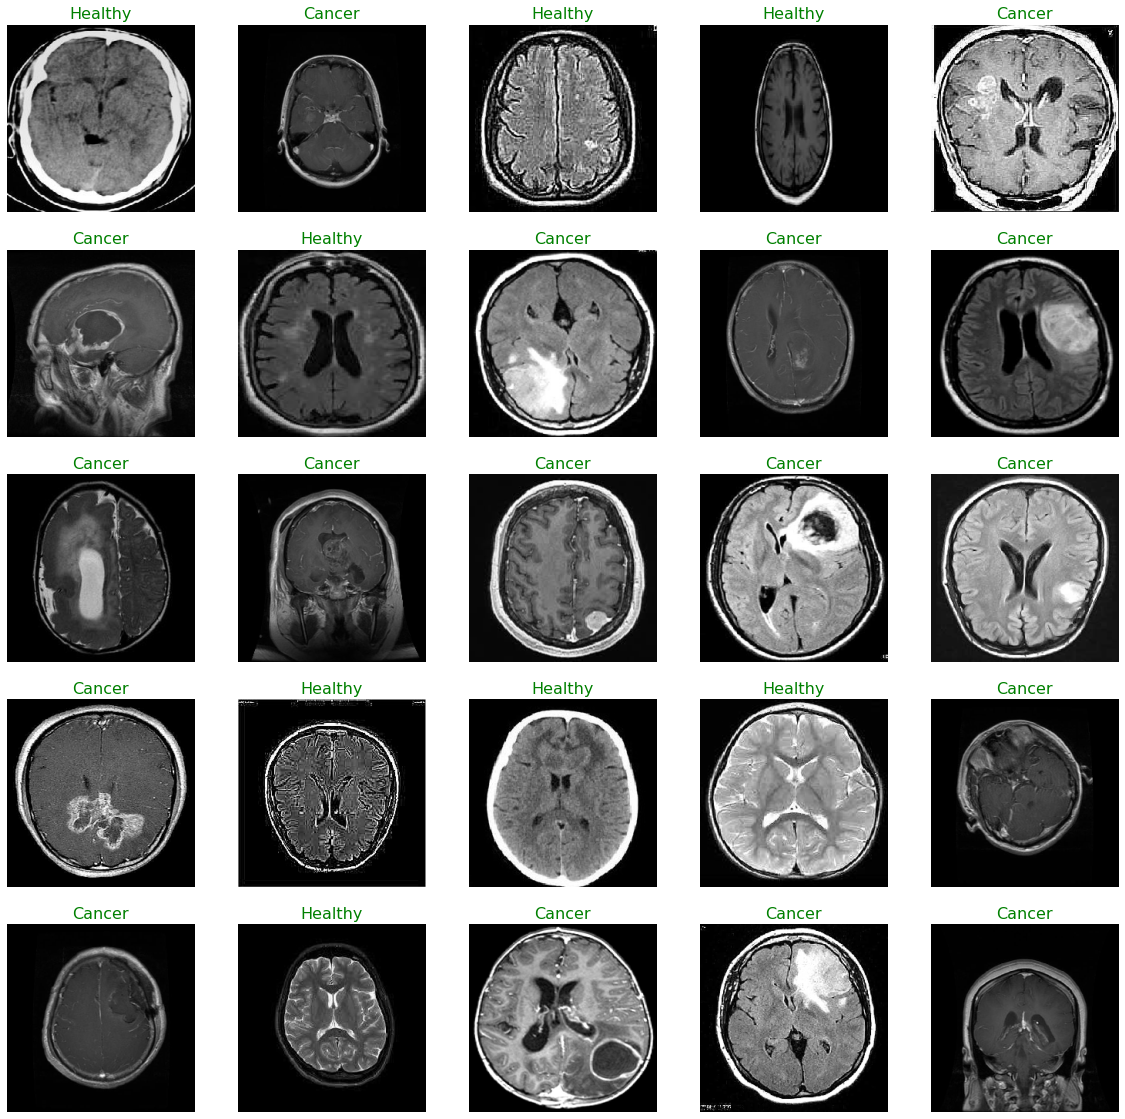

In [10]:
show_brain_images(train)

# Model Training

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D

#Defining Sequential Model
model = Sequential()

# defining conv-pool layer
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid", input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#adding flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))

#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

2022-11-04 18:27:57.287266: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 468512)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               59969664  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [12]:
#fitting model
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

2022-11-04 18:27:57.936069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
115/115 [==============================] - 73s 627ms/step - loss: 2.6272 - accuracy: 0.6940 - val_loss: 0.4027 - val_accuracy: 0.8391
Epoch 2/10
115/115 [==============================] - 67s 586ms/step - loss: 0.3486 - accuracy: 0.8658 - val_loss: 0.2615 - val_accuracy: 0.9043
Epoch 3/10
115/115 [==============================] - 68s 589ms/step - loss: 0.1822 - accuracy: 0.9299 - val_loss: 0.1617 - val_accuracy: 0.9370
Epoch 4/10
115/115 [==============================] - 68s 592ms/step - loss: 0.1050 - accuracy: 0.9625 - val_loss: 0.1644 - val_accuracy: 0.9511
Epoch 5/10
115/115 [==============================] - 69s 596ms/step - loss: 0.0832 - accuracy: 0.9766 - val_loss: 0.1208 - val_accuracy: 0.9641
Epoch 6/10
115/115 [==============================] - 68s 588ms/step - loss: 0.0936 - accuracy: 0.9739 - val_loss: 0.1218 - val_accuracy: 0.9533
Epoch 7/10
115/115 [==============================] - 68s 591ms/step - loss: 0.0490 - accuracy: 0.9872 - val_loss: 0.1609 - val_ac

# Visualizing Accuracy and Loss

Text(0.5, 1.0, 'Training and Validation Accuracy')

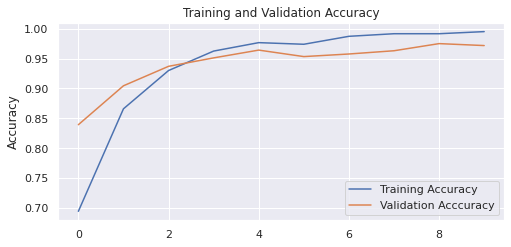

In [13]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Losses')

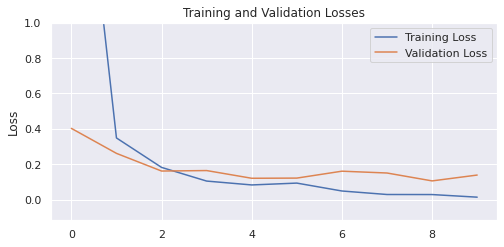

In [14]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

# Model Evaluation

In [15]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 9s 212ms/step - loss: 0.0930 - accuracy: 0.9812


[0.09302162379026413, 0.9811594486236572]

In [16]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [17]:
from sklearn.metrics import classification_report, accuracy_score
y_test = test_images.Labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      Cancer       0.98      0.99      0.98       759
     Healthy       0.99      0.97      0.98       621

    accuracy                           0.98      1380
   macro avg       0.98      0.98      0.98      1380
weighted avg       0.98      0.98      0.98      1380

Accuracy of the Model: 98.1159420289855 %


<AxesSubplot:>

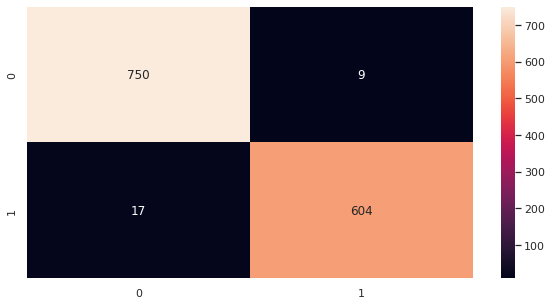

In [18]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')